In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [3]:
# Load data
data = pd.read_csv(r"C:\Users\Dell\Downloads\anxiety_analysis.csv")

In [4]:
data.head()

,Do you feel nervous?,Do you worry a lot?,Do you feel anxious about the future?,Do you have touble relaxing?,Do you find it hard to sit in one place for a while?,Do you get irritated easily?,Do you feel something scary might happen to you?,Anxiety Risk
0,3,1,1,0,3,0,3,Moderate Anxiety
1,2,0,1,2,1,1,2,Mild Anxiety
2,0,0,2,0,0,0,1,Minimal Anxiety
3,2,0,0,2,3,0,1,Mild Anxiety
4,1,2,0,1,1,0,1,Mild Anxiety


In [5]:
# Extracting categorical columns
categorical_cols = [
                    'Do you feel nervous?',
                    'Do you worry a lot?',
                    'Do you feel anxious about the future?',
                    'Do you have touble relaxing?',
                    'Do you find it hard to sit in one place for a while?',
                    'Do you get irritated easily?',
                    'Do you feel something scary might happen to you?'
]

In [6]:
# One-hot encode categorical variables
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_data = encoder.fit_transform(data[categorical_cols])

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Create a DataFrame with encoded features
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate encoded features with original data
data_encoded = pd.concat([data.drop(columns=categorical_cols), encoded_df], axis=1)

In [9]:
# Separate features (X) and target variable (y)
X = data_encoded.drop(columns=['Anxiety Risk'])
y = data_encoded['Anxiety Risk']

In [10]:
# Integer encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax') 
])

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

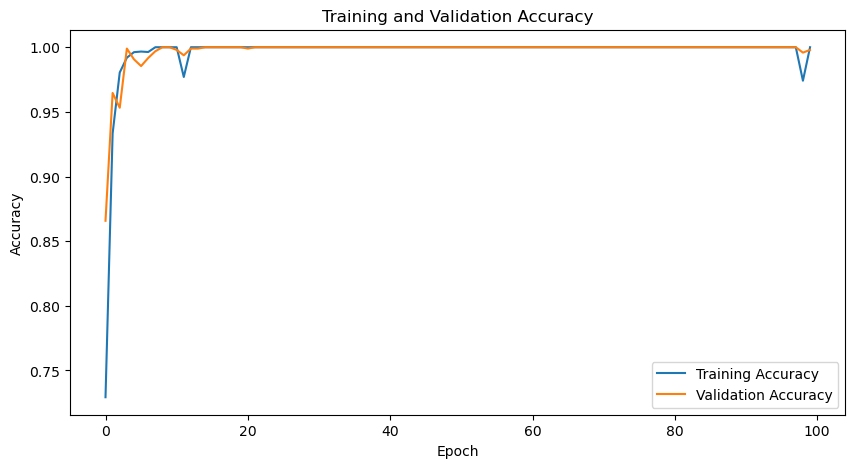

In [15]:
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

76/76 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 0.9992
Test Accuracy: 0.9991676807403564


In [17]:
# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

76/76 [==============================] - 0s 3ms/step


In [18]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Confusion Matrix:
[[ 788    0    0    0]
 [   0   39    0    0]
 [   0    0 1339    2]
 [   0    0    0  235]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       788
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00      1341
           3       0.99      1.00      1.00       235

    accuracy                           1.00      2403
   macro avg       1.00      1.00      1.00      2403
weighted avg       1.00      1.00      1.00      2403



In [19]:
# Save the trained model
model.save('nn_anx_model.h5')

# Save the OneHotEncoder
joblib.dump(encoder, 'one_hot_encoder_nn_anx.pkl')

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['one_hot_encoder_nn_anx.pkl']

Testing

In [22]:
import pandas as pd
import joblib
import numpy as np
import tensorflow as tf

# Load the saved neural network model
loaded_model = tf.keras.models.load_model('nn_anx_model.h5')

# Load the saved OneHotEncoder
loaded_encoder = joblib.load('one_hot_encoder_nn_anx.pkl')

# Prepare the input data
input_data = pd.DataFrame({
    'Do you feel nervous?': [0],
    'Do you worry a lot?': [0],
    'Do you feel anxious about the future?': [0],
    'Do you have touble relaxing?': [1],
    'Do you find it hard to sit in one place for a while?': [1],
    'Do you get irritated easily?': [0],
    'Do you feel something scary might happen to you?': [0]
})

# One-hot encode the input data
encoded_input = loaded_encoder.transform(input_data)

# Make predictions
predictions_prob = loaded_model.predict(encoded_input)
predictions = np.argmax(predictions_prob, axis=1)

# Inverse transform the predicted labels to get the actual class labels
predicted_labels = label_encoder.inverse_transform(predictions)

print("Predicted Labels:", predicted_labels)

1/1 [==============================] - 0s 78ms/step
Predicted Labels: ['Minimal Anxiety']
